#This File has Two Main Scripts:
#1. Trained EmoBERTa Model on Hybrid Strategy and Save it.
#2. Prediction: Used saved model and predict on unlabeled Dataset.

#Import Libraries and Mount drive

In [ ]:
import pandas as pd
import torch
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Load Dataset and Downsampled Adaptive to balance the classes

In [ ]:
# Load labeled dataset
file_path = "/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/NewDataset_Journal.xlsx"
df_labeled = pd.read_excel(file_path)

# Keep relevant columns
df_labeled = df_labeled[['text_ner', 'Adaptive']]
df_labeled.columns = ['text', 'label']
df_labeled.dropna(inplace=True)

# Convert labels to binary (1 = maladaptive, 0 = adaptive)
df_labeled['binary_label'] = df_labeled['label'].apply(lambda x: 1 if x == 'maladaptive' else 0)

# Downsample the labeled data to balance classes
adaptive = df_labeled[df_labeled['binary_label'] == 0]
maladaptive = df_labeled[df_labeled['binary_label'] == 1]
adaptive_downsampled = resample(adaptive, replace=False, n_samples=len(maladaptive), random_state=42)
df_downsampled = pd.concat([adaptive_downsampled, maladaptive])

# Split into training and holdout sets (90:10 splits)
X_finetune, X_holdout, y_finetune, y_holdout = train_test_split(
    df_labeled['text'], df_labeled['binary_label'], test_size=0.1, stratify=df_labeled['binary_label'], random_state=42
)

#Load tokenizer and Define Custom Dataset class

In [ ]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained('tae898/emoberta-base')

# Dataset class for tokenization
class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }
        if self.labels is not None:
            item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# Create DataLoaders for training and holdout datasets
train_down_dataset = TextDataset(df_downsampled['text'].tolist(), df_downsampled['binary_label'].tolist(), tokenizer)
finetune_dataset = TextDataset(X_finetune.tolist(), y_finetune.tolist(), tokenizer)
holdout_dataset = TextDataset(X_holdout.tolist(), y_holdout.tolist(), tokenizer)

train_down_loader = DataLoader(train_down_dataset, batch_size=16, shuffle=True)
finetune_loader = DataLoader(finetune_dataset, batch_size=16, shuffle=True)
holdout_loader = DataLoader(holdout_dataset, batch_size=16, shuffle=False)

#Load Model, Train and Save Model

In [ ]:
# Load model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = AutoModelForSequenceClassification.from_pretrained('tae898/emoberta-base', num_labels=2, ignore_mismatched_sizes=True)
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training function
def train_model(model, data_loader, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print(f"Epoch {epoch+1}/{epochs} completed.")

# Train the model
print("\nTraining on Downsampled Dataset...")
train_model(model, train_down_loader, optimizer, epochs=10)

print("\nFine-Tuning on Full 500 Labeled Entries...")
train_model(model, finetune_loader, optimizer, epochs=5)

# Save the trained model
model.save_pretrained('/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/Emoberta_refinement_maladaptive_model')

# Save the tokenizer as well
tokenizer.save_pretrained('/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/Emoberta_refinement_maladaptive_tokenizer')

print("Model and Tokenizer saved successfully!")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at tae898/emoberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Training on Downsampled Dataset...
Epoch 1/10 completed.
Epoch 2/10 completed.
Epoch 3/10 completed.
Epoch 4/10 completed.
Epoch 5/10 completed.
Epoch 6/10 completed.
Epoch 7/10 completed.
Epoch 8/10 completed.
Epoch 9/10 completed.
Epoch 10/10 completed.

Fine-Tuning on Full 500 Labeled Entries...
Epoch 1/5 completed.
Epoch 2/5 completed.
Epoch 3/5 completed.
Epoch 4/5 completed.
Epoch 5/5 completed.
Model and Tokenizer saved successfully!


#Prediction Setup (Used New Additional Unlabeled Data of 'Reflection' Entries Only for Prediction)

##Dataset Used: FinalDatasetToBeLabeled_Journal

*   Loading the saved model and tokenizer.
*   Preprocessing and tokenizing the unlabeled dataset.
*   Predicting the labels using the fine-tuned model.
*   Converting model predictions from 0/1 to "Adaptive" or "Maladaptive".
*   Saving the predictions back to the Excel file.





In [ ]:
# Load the saved model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/Emoberta_refinement_maladaptive_tokenizer')
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/Emoberta_refinement_maladaptive_model')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Load the unlabeled dataset
file_unlabeled = "/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/FinalDatasetToBeLabeled_Journal.xlsx"
df_unlabeled = pd.read_excel(file_unlabeled)

# Dataset class for tokenization
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer=None, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }
        return item

# Create DataLoader for unlabeled dataset
unlabeled_dataset = TextDataset(df_unlabeled['text_ner'].tolist(), tokenizer=tokenizer)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16, shuffle=False)

# Predict function
def predict_unlabeled(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
    return predictions

# Get predictions for unlabeled data
print("\nPredicting Labels for Unlabeled Data...")
unlabeled_predictions = predict_unlabeled(model, unlabeled_loader)

# Map predictions to 'Maladaptive' and 'Adaptive'
df_unlabeled['predicted_label'] = ['Maladaptive' if pred == 1 else 'Adaptive' for pred in unlabeled_predictions]

# Save the predictions back to the original unlabeled dataset
df_unlabeled.to_excel("/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/FinalDatasetToBeLabeled_Journal.xlsx", index=False)

print("Predictions saved in the unlabeled file!")


Predicting Labels for Unlabeled Data...
Predictions saved in the unlabeled file!


#Prediction Setup (Used Existing Initial Unlabeled Data of 'Reflection' Entries Only for Prediction i.e. 7201 records)

In [ ]:
# Load the saved model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/Emoberta_refinement_maladaptive_tokenizer')
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/Emoberta_refinement_maladaptive_model')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Load the unlabeled dataset
file_unlabeled = "/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/Unlabeled_Journal_Data_Initial.csv"
df_unlabeled = pd.read_csv(file_unlabeled)

# Dataset class for tokenization
class TextDataset(Dataset):
    def __init__(self, texts, tokenizer=None, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }
        return item

# Create DataLoader for unlabeled dataset
unlabeled_dataset = TextDataset(df_unlabeled['text_ner'].tolist(), tokenizer=tokenizer)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16, shuffle=False)

# Predict function
def predict_unlabeled(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            predictions.extend(preds.cpu().numpy())
    return predictions

# Get predictions for unlabeled data
print("\nPredicting Labels for Unlabeled Data...")
unlabeled_predictions = predict_unlabeled(model, unlabeled_loader)

# Map predictions to 'Maladaptive' and 'Adaptive'
df_unlabeled['predicted_label'] = ['Maladaptive' if pred == 1 else 'Adaptive' for pred in unlabeled_predictions]

# Save the predictions back to the original unlabeled dataset
df_unlabeled.to_csv("/content/drive/MyDrive/Team_Project/Refinement_Mal(adaptive)/Unlabeled_Journal_Data_Initial.csv", index=False)

print("Predictions saved in the unlabeled file!")


Predicting Labels for Unlabeled Data...
Predictions saved in the unlabeled file!


# Evaluation of Model Performance: ROC-AUC, Classification Report, and Confusion Matrix

ROC-AUC Score: 0.9650


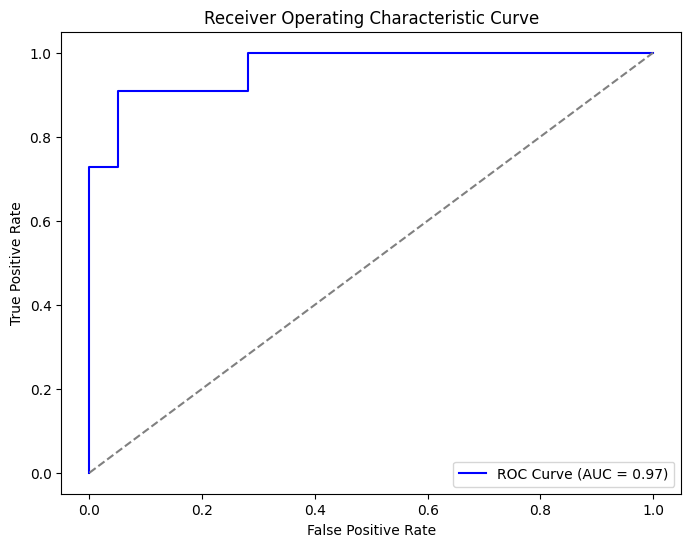


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        39
           1       0.50      1.00      0.67        11

    accuracy                           0.78        50
   macro avg       0.75      0.86      0.75        50
weighted avg       0.89      0.78      0.80        50


Confusion Matrix:
[[28 11]
 [ 0 11]]


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Predict probabilities (not just hard predictions) for ROC-AUC
def predict_probs(model, data_loader):
    model.eval()
    probs = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Apply softmax to get probabilities for both classes
            probs.extend(torch.softmax(outputs.logits, dim=1).cpu().numpy())
    return np.array(probs)

# Get probabilities for the holdout set
probs = predict_probs(model, holdout_loader)

# True labels for the holdout set
y_true = y_holdout.values  # Use true labels from the holdout set

# ROC-AUC Calculation
roc_auc = roc_auc_score(y_true, probs[:, 1])  # probs[:, 1] is for the maladaptive class (positive class)

# Print ROC-AUC score
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Compute ROC curve for plotting
fpr, tpr, thresholds = roc_curve(y_true, probs[:, 1])

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

# Classification report
y_pred = np.argmax(probs, axis=1)  # Convert probabilities to predictions
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)